# B站：神奇的布欧
# 微信：l1243278923

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import os

# 0. 判断GPU是否可用

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. 数据预处理

In [6]:
def loadData():
    xData = list()
    yData = list()
    labelNameDict = dict()
    dataPath = "./GarbageClassification/"
    listdir = os.listdir(dataPath)
    for label, labelName in enumerate(listdir):
        labelNameDict[label] = labelName
        for filename in os.listdir(dataPath + labelName):
            if not filename.endswith('.jpg'):
                continue
            imageSize = (32, 32)
            x = PIL.Image.open(dataPath + labelName + '/' + filename).resize(imageSize)
            x = torch.FloatTensor(np.array(x)) / 255
            # [32, 32, 3] -> [3, 32, 32]
            x = x.permute(2, 0, 1)
            xData.append(x)
            yData.append(label)
    return xData, yData, labelNameDict

In [7]:
xData, yData, labelNameDict = loadData()

In [8]:
len(xData), len(yData), xData[0].shape, yData[0]

(15515, 15515, torch.Size([3, 32, 32]), 0)

In [9]:
class Dataset(Data.Dataset):
    def __init__(self):
        pass
    def __len__(self):
        return len(xData)
    def __getitem__(self, i):
        return xData[i], yData[i]

In [10]:
dataset = Dataset()

In [11]:
# 数据集加载器
loader = Data.DataLoader(dataset=dataset,
                         batch_size=8,
                         shuffle=True,
                         drop_last=True)

In [12]:
x, y = next(iter(loader))

In [13]:
len(loader), x.shape, y

(1939, torch.Size([8, 3, 32, 32]), tensor([7, 2, 7, 0, 6, 4, 4, 2]))

# 2. 模型构建

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=3,
                              out_channels=16,
                              kernel_size=5,
                              stride=2,
                              padding=0)
        self.cnn2 = nn.Conv2d(in_channels=16,
                              out_channels=32,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.cnn3 = nn.Conv2d(in_channels=32,
                              out_channels=128,
                              kernel_size=7,
                              stride=1,
                              padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_features=128, out_features=12)
    def forward(self, x):
        # [8 3 32 32] -> [8 16 14 14]
        x = self.cnn1(x)
        x = self.relu(x)
        # [8 16 14 14] -> [8 32 14 14]
        x = self.cnn2(x)
        x = self.relu(x)
        # [8 32 14 14] -> [8 32 7 7]
        x = self.pool(x)
        # [8 32 7 7] -> [8 128 1 1]
        x = self.cnn3(x)
        x = self.relu(x)
        # [8 128 1 1] -> [8 128]
        x = x.flatten(start_dim=1)
        return self.fc(x)

In [18]:
model = Model().to(device)

In [19]:
model

Model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn3): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Linear(in_features=128, out_features=12, bias=True)
)

# 3. 训练

In [20]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fun = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(5):
        for step, (x, y) in enumerate(loader):
            out = model(x.to(device))
            loss = loss_fun(out.to("cpu"), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if step % 200 == 0:
                acc = (out.to("cpu").argmax(dim=1) == y).sum().item() / len(y)
                print(f"epoch：{epoch}轮，序号：{step:<5}，损失：{loss.item():<20}，准确率：{acc}")
    torch.save(model, "./8垃圾分类.model")

In [21]:
train()

epoch：0轮，序号：0    ，损失：2.503471851348877   ，准确率：0.125
epoch：0轮，序号：200  ，损失：1.2967288494110107  ，准确率：0.75
epoch：0轮，序号：400  ，损失：1.1134116649627686  ，准确率：0.5
epoch：0轮，序号：600  ，损失：1.2212257385253906  ，准确率：0.5
epoch：0轮，序号：800  ，损失：1.2191386222839355  ，准确率：0.625
epoch：0轮，序号：1000 ，损失：0.8548066020011902  ，准确率：0.75
epoch：0轮，序号：1200 ，损失：1.682559847831726   ，准确率：0.5
epoch：0轮，序号：1400 ，损失：0.9609918594360352  ，准确率：0.5
epoch：0轮，序号：1600 ，损失：1.003648042678833   ，准确率：0.625
epoch：0轮，序号：1800 ，损失：0.5490646958351135  ，准确率：0.875
epoch：1轮，序号：0    ，损失：0.31221550703048706 ，准确率：1.0
epoch：1轮，序号：200  ，损失：1.282550573348999   ，准确率：0.375
epoch：1轮，序号：400  ，损失：0.8704104423522949  ，准确率：0.75
epoch：1轮，序号：600  ，损失：0.9703871607780457  ，准确率：0.625
epoch：1轮，序号：800  ，损失：1.2325772047042847  ，准确率：0.625
epoch：1轮，序号：1000 ，损失：1.3303632736206055  ，准确率：0.75
epoch：1轮，序号：1200 ，损失：0.9955060482025146  ，准确率：0.75
epoch：1轮，序号：1400 ，损失：0.8197326064109802  ，准确率：0.75
epoch：1轮，序号：1600 ，损失：0.5793080925941467  ，准确率：0.75
epoch：1轮，序号：1800 ，损失：0.560654

# 4. 测试

In [22]:
@torch.no_grad()
def test():
    model = torch.load("./8垃圾分类.model").to("cpu")
    model.eval()
    correct = 0
    total = 0
    for i in range(100):
        x, y = next(iter(loader))
        out = model(x).argmax(dim=1)
        correct += (out == y).sum().item()
        total += len(y)
    print("准确率：" + str(correct / total))

In [23]:
test()

准确率：0.8175


# 5. 可视化

In [25]:
x, y = next(iter(loader))
model = torch.load("./8垃圾分类.model").to("cpu")
out = model(x).argmax(dim=1)
x.shape

torch.Size([8, 3, 32, 32])

<function matplotlib.pyplot.show(close=None, block=None)>

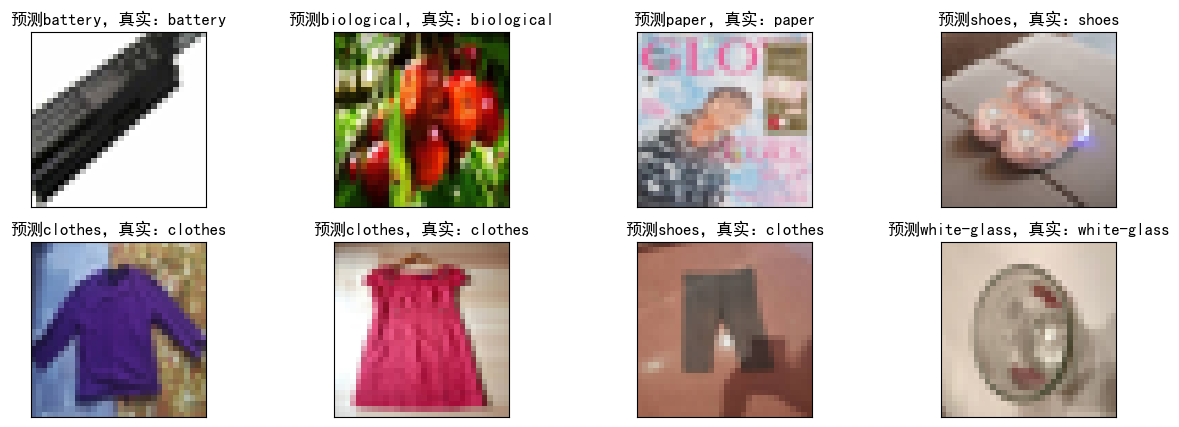

In [26]:
plt.rcParams['font.sans-serif'] = ['SimHei']
titles = [f"预测{labelNameDict[pre]}，真实：{labelNameDict[label]}" for pre, label in zip(out.tolist(), y.tolist())]
image = [img for img in x.permute(0, 2, 3, 1).numpy()]
plt.figure(figsize=(15, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show